# **차량 공유업체의 차량 파손 여부 분류하기**

## 0.미션

* 1) 미션1 : Data Preprocessing
    - **과제 수행 목표**
        - 모델링 수행을 위해 적절한 폴더 및 파일로 **일관성 있게 정리**해야 합니다.
        - 제공된 데이터 : Car_Images.zip
            * Car_Images : 차량의 정상/파손 이미지 무작위 수집

* 2) 미션2 : CNN 모델링
    - **과제 수행 목표**
        - Keras를 이용하여 모델을 3개 이상 생성하세요.
            - 모델 구조와 파라미터는 자유롭게 구성하세요.
            - 단, 세부 목차에서 명시한 부분은 지켜주세요.

* 3) 미션3 : Transfer Learning
    - **과제 수행 목표**
        - 성능 개선을 위해 다음의 두가지를 시도하세요.
            * Image Preprocessing Layer, Image Augmentation Layer를 통해 이미지를 변형시켜 봅시다.
            * Transfer Learning(Inception V3)
* 성능 가이드
    * Accuracy : 0.34~0.74

## 1.환경설정

* **세부 요구사항**
    - 경로 설정 : Google Colaboratory의 가상 컴퓨터 안에 데이터셋을 다운로드 받고 압축을 해제하세요.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.

In [1]:
!pip install keras --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.1.1 which is incompatible.


In [2]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

### (1) 라이브러리 불러오기

In [3]:
import gdown, zipfile
import os, glob, shutil
from tqdm import tqdm

from scipy import io
import numpy as np
import matplotlib.pyplot as plt

### (2) 데이터 불러오기

#### 1) 데이터 다운로드

In [4]:
def download_file(file_id, save_path) :
    if os.path.exists(save_path) :
        print(f'{save_path} 파일이 이미 존재합니다.')
        return

    gdown.download(id=file_id, output=save_path, quiet=False)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 2) 데이터 압축 해제

In [6]:
def dataset_extract(file_name) :
    with zipfile.ZipFile(file_name, 'r') as zip_ref :
        file_list = zip_ref.namelist()

        if os.path.exists(f'/content/{file_name[-14:-4]}/') :
            print(f'파일이 이미 존재합니다.')
            return

        else :
            for f in tqdm(file_list, desc = 'Extracting', unit = 'files' ) :
                zip_ref.extract(member = f, path = f'/content/{file_name[-14:-4]}/')

In [7]:
dataset_extract('/content/drive/MyDrive/2024.04.08_미니프로젝트 4차_실습자료/Car_Images.zip')

Extracting: 100%|██████████| 607/607 [00:20<00:00, 30.14files/s]


#### 2) 데이터 조회

In [8]:
# 폴더별 이미지 데이터 갯수 확인
abnormal = '/content/Images.zip/abnormal'
normal = '/content/Images.zip/normal'

print(f'abnormal : {len(os.listdir(abnormal))}')
print(f'normal : {len(os.listdir(normal))}')

abnormal : 303
normal : 302


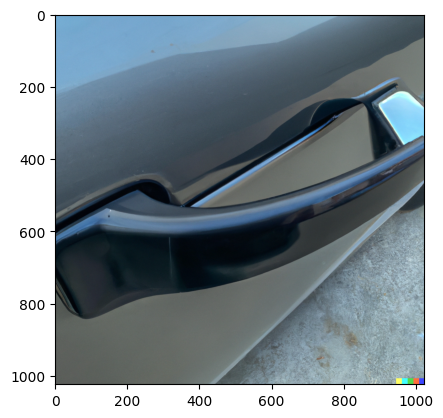

In [9]:
# 정상 차량 랜덤 이미지 확인 및 형태 확인
import random
images = os.listdir(normal)
random_image = random.choice(images)
random_image_path = os.path.join(normal, random_image)
image = plt.imread(random_image_path)
plt.imshow(image, cmap='gray')
plt.show()

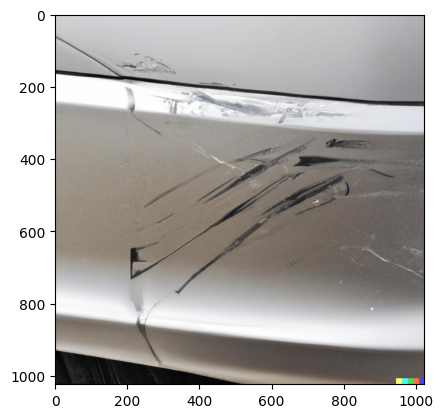

In [10]:
# 파손 차량 랜덤 이미지 확인 및 형태 확인
images = os.listdir(abnormal)
random_image = random.choice(images)
random_image_path = os.path.join(abnormal, random_image)
image = plt.imread(random_image_path)
plt.imshow(image, cmap='gray')
plt.show()

## 2.데이터 전처리
* 모델링을 위한 데이터 구조 만들기
    * X : 이미지를 array로 변환합니다.
    * Y : 이미지 갯수만큼 normal - 0, abnormal - 1 로 array를 만듭니다.

### (1) Y : 클래스 만들기
- **세부요구사항**
    - 전체 데이터에 대한 Y를 생성합니다.
    - normal, abnormal 데이터의 수를 확인하고 normal을 0, abnormal을 1로 지정합니다.

In [21]:
nor = os.listdir(normal)
abnor = os.listdir(abnormal)
Y_normal = np.zeros(len(nor))
Y_abnormal = np.ones(len(abnor)
Y = np.concatenate([Y_normal, Y_abnormal])
Y.shape

(605,)

In [22]:
from PIL import Image

nor_images = []
for filename in nor:
    image_path = os.path.join(normal, filename)
    image = Image.open(image_path)
    nor_images.append(image)
    
abnor_images = []
for filename in abnor:
    image_path = os.path.join(abnormal, filename)
    image = Image.open(image_path)
    nor_images.append(image)

### (2) X : 데이터 리스트 통합
- **세부요구사항**
    - 전체 이미지 데이터를 하나의 리스트로 통합합니다.

In [23]:
X = nor_images + abnor_images

### (3) 데이터셋 분리
- **세부요구사항**
    - 데이터 스플릿의 비율 (1) : train set, test set = 90%, 10%으로 설정하세요.
    - 데이터 스플릿의 비율 (2) : train set, valid set = 90%, 10%으로 설정하세요.

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

### (4) X : image to array
- **세부요구사항**
    * 모델링을 위해서는 np.array 형태로 데이터셋을 만들어야 합니다.
    * Training set / Validation set / Test set의 X는 이미지 형태로 되어있습니다.
    * 이미지 파일을 불러와 Training data, Validation data, Test data 각각 array 형태로 변환해 봅시다.

In [25]:
def images_to_arrays(image_data):
    images_array = []
    for image in image_data:
        image_array = np.array(image)
        images_array.append(image_array)
    return np.array(images_array)

x_train = images_to_arrays(x_train)
x_val = images_to_arrays(x_val)
x_test = images_to_arrays(x_test)

In [17]:
target_size = (64, 64)

def resize_images(image_data, target_size):
    resized_images = []
    for image in image_data:
        pil_image = Image.fromarray(image)
        resized_image = pil_image.resize(target_size)
        resized_images.append(np.array(resized_image))
    return np.array(resized_images)

x_train_rs = resize_images(x_train, target_size)
x_val_rs = resize_images(x_val, target_size)
x_test_rs = resize_images(x_test, target_size)

In [28]:
x_train.shape , x_val.shape, x_test.shape

((489, 1024, 1024, 3), (55, 1024, 1024, 3), (61, 1024, 1024, 3))

In [20]:
x_train_rs.shape, x_val_rs.shape, x_test_rs.shape

((489, 64, 64, 3), (55, 64, 64, 3), (61, 64, 64, 3))

## 3.모델링 I
* **세부요구사항**
    * 모델을 최소 3개 이상 만들고 성능을 비교합니다.
        * 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
        * 전처리 과정에서 생성한 Validation set을 적절하게 사용하세요.
        * Early Stopping을 반드시 사용하세요.
            * 최적의 가중치를 모델에 적용하세요.

### (1) 모델 1
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

In [29]:
import keras

from keras.backend import clear_session
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout
from keras.layers import Conv2D, MaxPool2D

#### 1) 구조 설계

In [49]:
model1 = Sequential()

model1.add(Input(shape=(64,64,3)))
model1.add(Conv2D(filters=64,          
                   kernel_size=(3,3),   
                   strides=(1,1),       
                   padding='same',      
                   activation='relu',   
                   ))
model1.add(Conv2D(filters=64,          
                   kernel_size=(3,3),   
                   strides=(1,1),       
                   padding='same',      
                   activation='relu',   
                   ))
model1.add(MaxPool2D(pool_size=(2,2),  
                      strides=(2,2)     
                      ))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))

model1.add(Conv2D(filters=128,         
                   kernel_size=(3,3),   
                   strides=(1,1),       
                   padding='same',      
                   activation='relu',   
                   ))
model1.add(Conv2D(filters=128,         
                   kernel_size=(3,3),   
                   strides=(1,1),       
                   padding='same',      
                   activation='relu',   
                   ))
model1.add(MaxPool2D(pool_size=(2,2),  
                      strides=(2,2)     
                      ))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))

model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(Dense(2, activation='softmax'))

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      16,777,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,039,682 (65.00 MB)

 Trainable params: 17,039,298 (65.00 MB)

 Non-trainable params: 384 (1.50 KB)

#### 2) 학습

In [50]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',         
                   min_delta=0,                
                   patience=3,                 
                   verbose=1,
                   restore_best_weights=True)  

In [52]:
model1.fit(x_train_rs, y_train, epochs=20, verbose=1,
           validation_data=(x_val_rs, y_va),
           callbacks=[es]
           )

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 459ms/step - accuracy: 0.5813 - loss: 7.6659 - val_accuracy: 0.5818 - val_loss: 9.0680
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8101 - loss: 0.5089 - val_accuracy: 0.3818 - val_loss: 8.7950
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8452 - loss: 0.3202 - val_accuracy: 0.4182 - val_loss: 4.7810
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8569 - loss: 0.2592 - val_accuracy: 0.4364 - val_loss: 4.3790
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9561 - loss: 0.1345 - val_accuracy: 0.5455 - val_loss: 2.7944
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9583 - loss: 0.0930 - val_accuracy: 0.4909 - val_loss: 4.1107
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9798 - loss: 0.0698 - val_accuracy: 0.6727 - val_loss: 1.4697
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9938 - loss: 0.0352 - val_accuracy: 0.7455 -

#### 3) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

In [54]:
pred = model1.predict(x_test_rs)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [64]:
pred1 = np.argmax(pred, axis=1)

In [65]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(classification_report(y_test, pred1))
print(confusion_matrix(y_test, pred1))

              precision    recall  f1-score   support

         0.0       0.81      0.91      0.85        32
         1.0       0.88      0.76      0.81        29

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.83        61

[[29  3]
 [ 7 22]]


## 4.모델링 II
* **세부요구사항**
    - image_dataset_from_directory를 이용하여 training set, validation set을 만들어봅시다.
    - 성능을 높이기 위해서 다음의 두가지를 시도해 봅시다.
        - Image Preprocessing Layer, Image Augmentation Layer를 통해 이미지를 변형시켜 봅시다.
        - 사전 학습된 모델(Transfer Learning)을 가져다 사용해 봅시다.

### (1) image_dataset_from_directory

### (2) Transfer Learning

#### 1) Inception V3 모델을 불러와서 저장하기
* include_top=False로 설정하여 분류기를 제외하고 미리 학습된 가중치 imagenet을 로드합니다.
* .trainable을 False로 설정하여 불러온 모델의 모든 레이어들을 Frozen 시켜 가중치를 고정합니다.

#### 2) Inception V3 모델과 연결하여 구조 설계
* Inception V3을 불러온 후, 다른 레이어와 연결하기
* Image Preprocessing Layer, Image Augmentation Layer를 사용해보세요.

#### 3) 학습

#### 4) 성능 평가